In [1]:
# %pip install tensorflow==2.15.0 pillow==10.2.0 scipy==1.12.0 uuid==1.30 matplotlib pandas==2.2.0 seaborn==0.13.2 scikit-learn==1.4.1.post1 
# %pip install numpy skl2onnx onnxruntime onnx statsmodels xgboost onnxmltools pydot pyquicksetup 
# %pip install mlprodict
# %pip install pytest

In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
from skl2onnx.common.data_types import FloatTensorType
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

C:\Users\ninol\AppData\Local\Temp\ipykernel_155448\888243798.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from utils.tests_custom import Tests

In [19]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

X_train, y_train = train_data.drop(['checked'], axis=1), train_data['checked']
X_test, y_test = test_data.drop(['checked'], axis=1), test_data['checked']

In [20]:
# Let's load the model
new_session = rt.InferenceSession("models/model_2.onnx")
print(type(new_session))

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
confusion = confusion_matrix(y_test, y_pred_onnx2[0])
precision = precision_score(y_test, y_pred_onnx2[0])
recall = recall_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)
print(confusion)
print('Precision', precision, 'recall', recall)


<class 'onnxruntime.capi.onnxruntime_inference_collection.InferenceSession'>
Accuracy of the ONNX model:  0.9849742981415579
[[2256    6]
 [  32  235]]
Precision 0.975103734439834 recall 0.8801498127340824


In [21]:
test = Tests()

# Run different tests
results = test.testGenderOnnx(new_session, X_test, y_test, which='all', verbose=False)
results_b = test.testAgeOnnx(new_session, X_test, y_test, which='all')
results_c = test.testImmigrantsOnnx(new_session, X_test, y_test)
results_d = test.testYoungImmigrantsOnnx(new_session, X_test, y_test)


RUNNING GENDER MUTATION TESTS:
Original Accuracy:  0.9849742981415579 mean risk score: 0.09529458283906682
Euclidian Distance to Ground Truth 6.164414002968976
All Male Accuracy:  0.9849742981415579 mean risk score: 0.09450375642546462
Euclidian Distance to Ground Truth 6.164414002968976
All Female Accuracy:  0.9857651245551602 mean risk score: 0.09608540925266904
Euclidian Distance to Ground Truth 6.0
Swapped Genders Accuracy:  0.9857651245551602 mean risk score: 0.09529458283906682
Euclidian Distance to Ground Truth 6.0
Random Genders Accuracy:  0.9845788849347569 mean risk score: 0.09489916963226572
Euclidian Distance to Ground Truth 6.244997998398398
RUNNING AGE MUTATION TESTS:
Original Accuracy:  0.9849742981415579 mean risk score: 0.09529458283906682
Euclidian Distance to Ground Truth 6.164414002968976
All 25 Accuracy:  0.977856860419138 mean risk score: 0.0937129300118624
Euclidian Distance to Ground Truth 7.483314773547883
All 45 Accuracy:  0.9766706207987347 mean risk score: 0

# Distributions
Small investigation into dataset distributions to motivate normalized/uniform random tests.

49.40332147093713
9.822235974220519


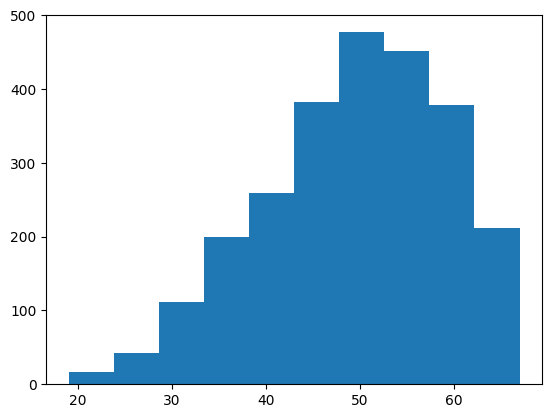

In [22]:
import matplotlib.pyplot as plt
plt.hist(X_test['persoon_leeftijd_bij_onderzoek'])
print(np.mean(X_test['persoon_leeftijd_bij_onderzoek']))
print(np.std(X_test['persoon_leeftijd_bij_onderzoek']))

49.43592634731447
9.796798681016659


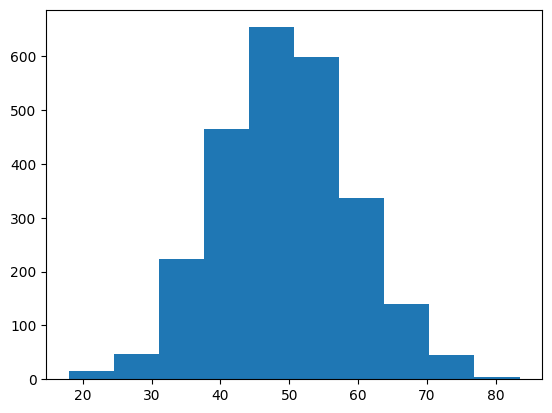

In [23]:
ran = np.random.normal(loc=49.40332147093713, scale=9.822235974220519, size=len(X_test['persoon_leeftijd_bij_onderzoek']))
plt.hist(ran)
print(np.mean(ran))
print(np.std(ran))

0.48279952550415184
0.4997040560943224


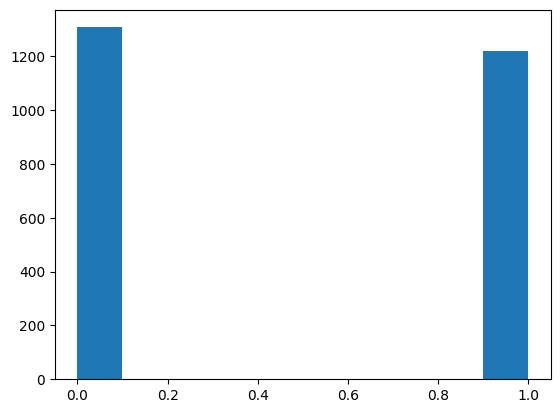

In [24]:
plt.hist(X_test['persoonlijke_eigenschappen_spreektaal_anders'])
print(np.mean(X_test['persoonlijke_eigenschappen_spreektaal_anders']))
print(np.std(X_test['persoonlijke_eigenschappen_spreektaal_anders']))

# Retesting our own models

In [3]:
tester = Tests()

### ORIGINAL

In [4]:
# Load original dataset 
csv_path = 'data/synth_data_for_training.csv'
data = pd.read_csv(csv_path)

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Do a second split to make it a fair comparison between models
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
selector = VarianceThreshold()
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
pipeline = Pipeline(steps=[('selector', selector), ('classification', classifier)])

In [6]:
# Pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)

# Conversion to ONNX and testing
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
confusion = confusion_matrix(y_test, y_pred_onnx[0])
precision = precision_score(y_test, y_pred_onnx[0])
recall = recall_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)
print(confusion)
print('Precision', precision, 'recall', recall)

Accuracy of the original model:  0.9474100434954528
Accuracy of the ONNX model:  0.9474100434954528
[[2228   34]
 [  99  168]]
Precision 0.8316831683168316 recall 0.6292134831460674


In [7]:
tester.testGenderOnnx(pipeline, X_test, y_test)
tester.testAgeOnnx(pipeline, X_test, y_test)
tester.testImmigrantsOnnx(pipeline, X_test, y_test)
tester.testYoungImmigrantsOnnx(pipeline, X_test, y_test)

RUNNING GENDER MUTATION TESTS:
Original Accuracy:  0.9474100434954528 mean risk score: 0.07987346777382365
Euclidian Distance to Ground Truth 11.532562594670797
All Male Accuracy:  0.9454329774614472 mean risk score: 0.07315144325820483
Euclidian Distance to Ground Truth 11.74734012447073
All Female Accuracy:  0.9470146302886516 mean risk score: 0.09529458283906682
Euclidian Distance to Ground Truth 11.575836902790225
Swapped Genders Accuracy:  0.9450375642546461 mean risk score: 0.088572558323448
Euclidian Distance to Ground Truth 11.789826122551595
Random Genders Accuracy:  0.9478054567022538 mean risk score: 0.08422301304863583
Euclidian Distance to Ground Truth 11.489125293076057
RUNNING AGE MUTATION TESTS:
Original Accuracy:  0.9474100434954528 mean risk score: 0.07987346777382365
Euclidian Distance to Ground Truth 11.532562594670797
All 25 Accuracy:  0.9177540529853697 mean risk score: 0.13483590351917754
Euclidian Distance to Ground Truth 14.422205101855956
All 45 Accuracy:  0.9

{'best': [0.9118228548833531, 14.933184523068078],
 'young': [0.8928430209568999, 16.46207763315433],
 'worst': [0.7030446816923686, 27.40437921208944]}

### AUGMENTED / OUR GOOD MODEL

In [4]:
# Load augmented dataset
train_csv_path = 'data/goodTrain.csv'
test_csv_path = 'data/goodTest.csv'

train = pd.read_csv(train_csv_path)
y_train = train['checked']
X_train = train.drop(['checked'], axis=1)
test = pd.read_csv(test_csv_path)
y_test = test['checked']
X_test = test.drop(['checked'], axis=1)
y = pd.concat([y_train, y_test])
X = pd.concat([X_train, X_test])
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
# Features to pass (Deemed the dropped features to subjective)
features_to_pass = X_train.columns.tolist()
print(len(features_to_pass))

features_to_delete = ['competentie_vakdeskundigheid_toepassen', 'pla_historie_ontwikkeling', 'afspraak_inspanningsperiode',
                     'afspraak_laatstejaar_aantal_woorden', 'afspraak_aantal_woorden', 'afspraak_signaal_voor_medewerker',
                     'persoonlijke_eigenschappen_uitstroom_verw_vlgs_klant', 'persoonlijke_eigenschappen_taaleis_voldaan',
                    'competentie_kwaliteit_leveren', 'competentie_gedrevenheid_en_ambitie_tonen',
                     'persoonlijke_eigenschappen_opstelling', 'competentie_overtuigen_en_beïnvloeden', 'competentie_aansturen',
                     'competentie_other', 'competentie_op_de_behoeften_en_verwachtingen_van_de__klant__richten', 'persoonlijke_eigenschappen_houding_opm',
                     'competentie_materialen_en_middelen_inzetten', 'persoonlijke_eigenschappen_leergierigheid_opm', 'competentie_formuleren_en_rapporteren',
                     'persoonlijke_eigenschappen_initiatief_opm', 'competentie_onderzoeken', 'persoonlijke_eigenschappen_presentatie_opm',
                     'competentie_met_druk_en_tegenslag_omgaan', 'persoonlijke_eigenschappen_communicatie_opm', 'persoonlijke_eigenschappen_doorzettingsvermogen_opm',
                     'competentie_instructies_en_procedures_opvolgen', 'competentie_leren', 'competentie_omgaan_met_verandering_en_aanpassen',
                     'persoonlijke_eigenschappen_flexibiliteit_opm', 'persoonlijke_eigenschappen_zelfstandigheid_opm', 'checked']
print(len(features_to_delete))

# Elements of features_to_delete but not of features_to_pass
print(([x for x in features_to_delete if x not in features_to_pass]))
print(len(features_to_pass) - len(features_to_delete))
features_to_pass = [x for x in features_to_pass if x not in features_to_delete]
print(len(features_to_pass))


315
31
['checked']
284
285


In [6]:
# Scaler
standardizer = StandardScaler()

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("binned",  KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['persoon_leeftijd_bij_onderzoek']),
        ('passthrough', 'passthrough', features_to_pass)
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Set verbose_feature_names to False
)

# Classifier
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('standardization', standardizer), ('classification', classifier)])

In [7]:
# Pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)

# Conversion to ONNX and testing
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue

        t = FloatTensorType([None, 1])

        inputs.append((k, t))
    return inputs

initial_inputs = convert_dataframe_schema(X_test)
onnx_model = convert_sklearn(
    pipeline, initial_types=initial_inputs,
    target_opset=12)

inputs = {c: X_test[c].values for c in X_test.columns}
for (c, _) in initial_inputs:
    inputs[c] = inputs[c].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
# inputs = {c: X_test[c].values for c in X_test.columns}
y_pred_onnx =  sess.run(None, inputs)

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
confusion = confusion_matrix(y_test, y_pred_onnx[0])
precision = precision_score(y_test, y_pred_onnx[0])
recall = recall_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)
print(confusion)
print('Precision', precision, 'recall', recall)

c:\Users\ninol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Accuracy of the original model:  0.9463057466163746
Accuracy of the ONNX model:  0.9463057466163746
[[3990   68]
 [ 174  275]]
Precision 0.8017492711370262 recall 0.6124721603563474


In [8]:
tester.testGenderOnnx(pipeline, X_test, y_test)
tester.testAgeOnnx(pipeline, X_test, y_test)
tester.testImmigrantsOnnx(pipeline, X_test, y_test)
tester.testYoungImmigrantsOnnx(pipeline, X_test, y_test)

RUNNING GENDER MUTATION TESTS:
Original Accuracy:  0.9463057466163746 mean risk score: 0.07610383847348569
Euclidian Distance to Ground Truth 15.556349186104045
All Male Accuracy:  0.9463057466163746 mean risk score: 0.07610383847348569
Euclidian Distance to Ground Truth 15.556349186104045
All Female Accuracy:  0.9463057466163746 mean risk score: 0.07610383847348569
Euclidian Distance to Ground Truth 15.556349186104045
Swapped Genders Accuracy:  0.9463057466163746 mean risk score: 0.07610383847348569
Euclidian Distance to Ground Truth 15.556349186104045
Random Genders Accuracy:  0.9463057466163746 mean risk score: 0.07610383847348569
Euclidian Distance to Ground Truth 15.556349186104045
RUNNING AGE MUTATION TESTS:
Original Accuracy:  0.9463057466163746 mean risk score: 0.07610383847348569
Euclidian Distance to Ground Truth 15.556349186104045
All 25 Accuracy:  0.9398713112935434 mean risk score: 0.06656312402928777
Euclidian Distance to Ground Truth 16.46207763315433
All 45 Accuracy:  0

{'best': [0.921677390725538, 18.788294228055936],
 'young': [0.9321056134901264, 17.4928556845359],
 'worst': [0.5813179498557799, 43.439613257946945]}